# **TRABALHO: TRATAMENTO DE DADOS DESBALANCEADOS**

## **IMPORTAÇÃO DAS BIBLIOTECAS**

In [1]:
# Para análsie
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

In [2]:
# Escalonamento dos dados
from sklearn.preprocessing import StandardScaler
# Treino de modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Treino e teste
from sklearn.metrics import accuracy_score, recall_score, roc_curve, roc_auc_score, precision_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, auc

In [3]:
# Métodos de desbalanceamentos
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [5]:
# Para o excel
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font, Border, Side, Alignment

## **FUNÇÕES**

In [55]:
def draw_graphics(data):
    # FUNÇÃO QUE DESENHA OS GRÁFICOS E QUE SALVA ELES NA PASTA GRAPHICS/<METHOD>, BASEADOS NOS DADOS DOS DATASETS QUE SÃO ENVIADOS
    
    # Cria a pasta que vai conter as imagens dos gráficos
    os.makedirs(f"graphics", exist_ok=True)
    # Primeiros 10 linhas
    print("Dez primeiras linhas do dataset:\n");
    display(data.head(10));
    print("\n")
    
    # Análise da frequência de cada classe
    print("Análise da frequência de cada classe")
    print(data['Class'].value_counts()) 
    print("\n")

    # Plot de um gráfico que conta as classes desbalanceadas e as normais
    plt.figure(figsize=(10,6))
    sns.countplot(x='Class', data=data)
    plt.grid(True)
    plt.title(f"Frequências das classe )")
    plt.savefig(f"graphics/countplot.png");
    print("\n")

    # Correlação entre cada um dos dados
    plt.figure(figsize=(20,12))
    corr = data.corr()
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.grid(True)
    plt.title(f"Gráfico de relação entre as variáveis )")
    plt.savefig(f"graphics/heatmap-corr.png");
    print("\n")
    

In [7]:
def fix_width_cell(ws):
    # Vai reajustar as colunas do excel para o tamanho do maior elemento dele
    for coll in ws.columns:
        max_len = 0
        col_letter = coll[0].column_letter

        for cell in coll:
            cell.alignment = Alignment(horizontal="left")
            try:
                if cell.value:
                    max_len = max(max_len, len(str(cell.value)))
            except:
                pass

        ws.column_dimensions[col_letter].width = max_len + 2  # margem extra


In [8]:
def save_sheet(model, method, accur, recall, prec, f1, prec_recall, roc):
    # Salva os dados no excel
    wb = False;

    # tenta abrir o arquivo e, caso não exista, cria ele
    try:
        wb = load_workbook("resultados.xlsx")
        ws = wb.active
    except:
        wb = Workbook()
        ws = wb.active
        ws.title = "Resultados"

    # Encontra a próxima linha vazia
    row = ws.max_row + 2   # +2 para criar linha em branco entre blocos
    row_tmp = 0 # vai ser usado para encontrar as colunas já existente

    # Vai passar por cada linha e, caso encontre o método e o modelo em uma linha, ele atualiza o row para sua linha
    for line in ws.iter_rows(values_only= True):
        row_tmp = row_tmp + 1
        if model in line and method in line:
            row = row_tmp

    # Adiciona no excel e edita na coluna da linha row
    
    ws[f"A{row}"] = "Modelo"
    ws[f"A{row}"].font = Font(bold=True)
    ws[f"B{row}"] = model
    ws[f"B{row}"].font = Font(italic=True)

    ws[f"C{row}"] = "Método"
    ws[f"C{row}"].font = Font(bold=True)
    ws[f"D{row}"] = method
    ws[f"D{row}"].font = Font(italic=True)

    ws[f"A{row+1}"] = "Acurácia"
    ws[f"A{row+1}"].font = Font(bold=True)
    ws[f"A{row+2}"] = accur

    ws[f"B{row+1}"] = "Recall"
    ws[f"B{row+1}"].font = Font(bold=True)
    ws[f"B{row+2}"] = recall

    ws[f"C{row+1}"] = "Precision"
    ws[f"C{row+1}"].font = Font(bold=True)
    ws[f"C{row+2}"] = prec

    ws[f"D{row+1}"] = "F1-Score"
    ws[f"D{row+1}"].font = Font(bold=True)
    ws[f"D{row+2}"] = f1

    ws[f"E{row+1}"] = "Precision-Recall"
    ws[f"E{row+1}"].font = Font(bold=True)
    ws[f"E{row+2}"] = prec_recall

    ws[f"F{row+1}"] = "AUC-ROC"
    ws[f"F{row+1}"].font = Font(bold=True)
    ws[f"F{row+2}"] = roc

    fix_width_cell(ws)
    wb.save("resultados.xlsx")
    wb.close()

In [9]:
def train_model(_model, listTrain):
    # FUNÇÃO QUE CRIA OS MODELOS DE ML, TREINA-O E FAZ PREVISÕES
    # RETORNA AS PREVISÕES E O MODELO
    
    # Criação do modelo
    model = _model;
    model.fit(listTrain[0], listTrain[1])
    #fazendo previsões no conjunto de teste

    # envia as previsões e o modelo
    return model
    

In [10]:
def print_infos(model, listTest, nameModel, method, save = True):
    # IMPRIME AS MÉTRICAS E OS GRÁFICOS, ALÉM DE SALVAR AS MÉTRICAS NO EXCEL E OS GRÁFICOS NAS PASTAS model/<nameMode>/

    prev = model.predict(listTest[0])
    prob = model.predict_proba(listTest[0])[:, 1]
    
    # cria a pasta para o determinado modelo
    os.makedirs(f"models/{nameModel}", exist_ok=True)
    #calculando acurácia
    accuracy = accuracy_score(listTest[1], prev)
    recall = recall_score(listTest[1], prev)
    precision = precision_score(listTest[1], prev)
    f1Score = f1_score(listTest[1], prev)
    print(f"Acurácia do modelo: {accuracy:.2f}\n")
    print(f"Recall do modelo: {recall:.2f}\n")
    print(f"Precision do modelo: {precision:.2f}\n")
    print(f"F1_Score do modelo: {f1Score:.2f}\n")
    
    #Curva Precision-Recall
    precision_prec_recall, recall_prec_recall, thresholds = precision_recall_curve(listTest[1], prob)
    metric_prec_recall = auc(recall_prec_recall, precision_prec_recall)
    print(f"Precision-Recall: {metric_prec_recall:.2f}")

    # Curva ROC-AUC
    precision_roc_auc, recall_roc_auc, thresholds_roc_auc = roc_curve(listTest[1], prob)
    metric_roc_auc = auc(precision_roc_auc, recall_roc_auc)
    print(f"ROC-AUC: {metric_roc_auc:.2f}")
    
    #printando o relatório de classificação completo
    print("Relatório de Classificação:")
    print(classification_report(listTest[1], prev))
    
    #printando a matriz de confusão
    print(f"Matriz de Confusão - {nameModel} - {method}:")
    plt.figure(figsize=(9,6))
    confusion_matrix_graphic = confusion_matrix(listTest[1], prev)
    sns.heatmap(confusion_matrix_graphic, annot=True, fmt='d', cmap='Purples', xticklabels=['Normal', 'Fráude'], yticklabels=['Normal', 'Fráude'])
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {nameModel} - {method}')
    plt.savefig(f"models/{nameModel}/confusion-matrix-{method}.png")
    plt.show()
    
    #Curva Precision-Recall
    plt.figure(figsize=(9,6))
    plt.plot(recall_prec_recall, precision_prec_recall, label=f'AUC = {metric_prec_recall:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Curva Precision-Recall {nameModel} - {method}')
    plt.legend()
    plt.savefig(f"models/{nameModel}/pr-recall-curve-{method}.png")
    plt.show()

    #Curva Precision-Recall
    plt.figure(figsize=(9,6))
    plt.plot(precision_roc_auc, recall_roc_auc, label=f'AUC = {metric_roc_auc:.4f}')
    plt.xlabel('Precission')
    plt.ylabel('Recall')
    plt.title(f'Curva AUC-ROC {nameModel} - {method}')
    plt.legend()
    plt.savefig(f"models/{nameModel}/auc-roc-curve-{method}.png")
    plt.show()

    if save:
            save_sheet(nameModel, method, accuracy, recall, precision, f1Score, metric_prec_recall, metric_roc_auc)

    # dicionário com os dados das curvas de Precisão-Recall e AUC-ROC
    dictCurve = {
        "pr_rec": [precision_prec_recall, recall_prec_recall, metric_prec_recall],
        "auc_roc": [precision_roc_auc, recall_roc_auc, metric_roc_auc],
    }
    return dictCurve

In [11]:
def print_curve(dict1, dict2, dict3, method):
    # Condensa todos os gráficos de Precisão-Recall em um único gráfico, a mesma coisa com o gráfico de AUC-ROC
    # Curva Precision-Recall
    plt.figure(figsize=(6,4))
    plt.plot(dict1["pr_rec"][0], dict1["pr_rec"][1], label=f'KNN = {dict1["pr_rec"][2]:.4f}', color='green', lw=2)
    plt.plot(dict2["pr_rec"][0], dict2["pr_rec"][1], label=f'Logistic Regression = {dict2["pr_rec"][2]:.4f}', color='red', lw=2)
    plt.plot(dict3["pr_rec"][0], dict3["pr_rec"][1], label=f'Random Forest = {dict3["pr_rec"][2]:.4f}', color='blue', lw=2)
    plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Curva Precision-Recall {method}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"models/pr-recall-curve-{method}.png")
    plt.show()

    #Curva Precision-Recall
    plt.figure(figsize=(6,4))
    plt.plot(dict1["auc_roc"][0], dict1["auc_roc"][1], label=f'KNN = {dict1["auc_roc"][2]:.4f}', color='green', lw=2)
    plt.plot(dict2["auc_roc"][0], dict2["auc_roc"][1], label=f'Logistic Regression = {dict2["auc_roc"][2]:.4f}', color='red', lw=2)
    plt.plot(dict3["auc_roc"][0], dict3["auc_roc"][1], label=f'Random Forest = {dict3["auc_roc"][2]:.4f}', color='blue', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precission')
    plt.ylabel('Recall')
    plt.title(f'Curva AUC-ROC {method}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"models/auc-roc-curve-{method}.png")
    plt.show()

## **ANÁLISE EXPLORATÓRIA**

In [12]:
# Carrega a base de dados
# Para o Colab
#path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
#dataset = pd.read_csv(path+"/creditcard.csv")

# Para Local
dataset = pd.read_csv("./creditcard.csv")

# Escalona os dados
scaler = StandardScaler()

dataset['Amount'] = scaler.fit_transform(dataset['Amount'].values.reshape(-1, 1))
dataset['Time'] = scaler.fit_transform(dataset['Time'].values.reshape(-1, 1))



Dez primeiras linhas do dataset:



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0
5,-1.996541,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.338556,0
6,-1.996499,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.333279,0
7,-1.996436,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,-0.190107,0
8,-1.996436,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.019392,0
9,-1.996394,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.338516,0




Análise da frequência de cada classe
Class
0    284315
1       492
Name: count, dtype: int64








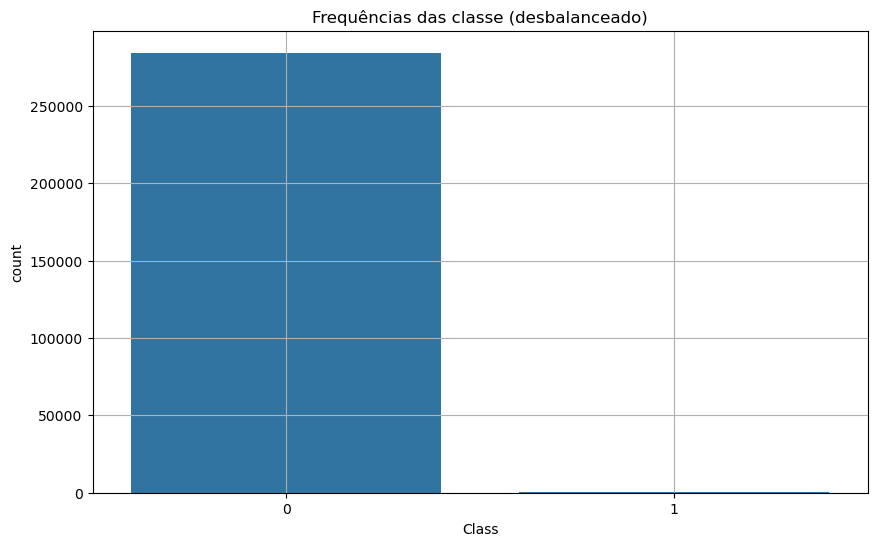

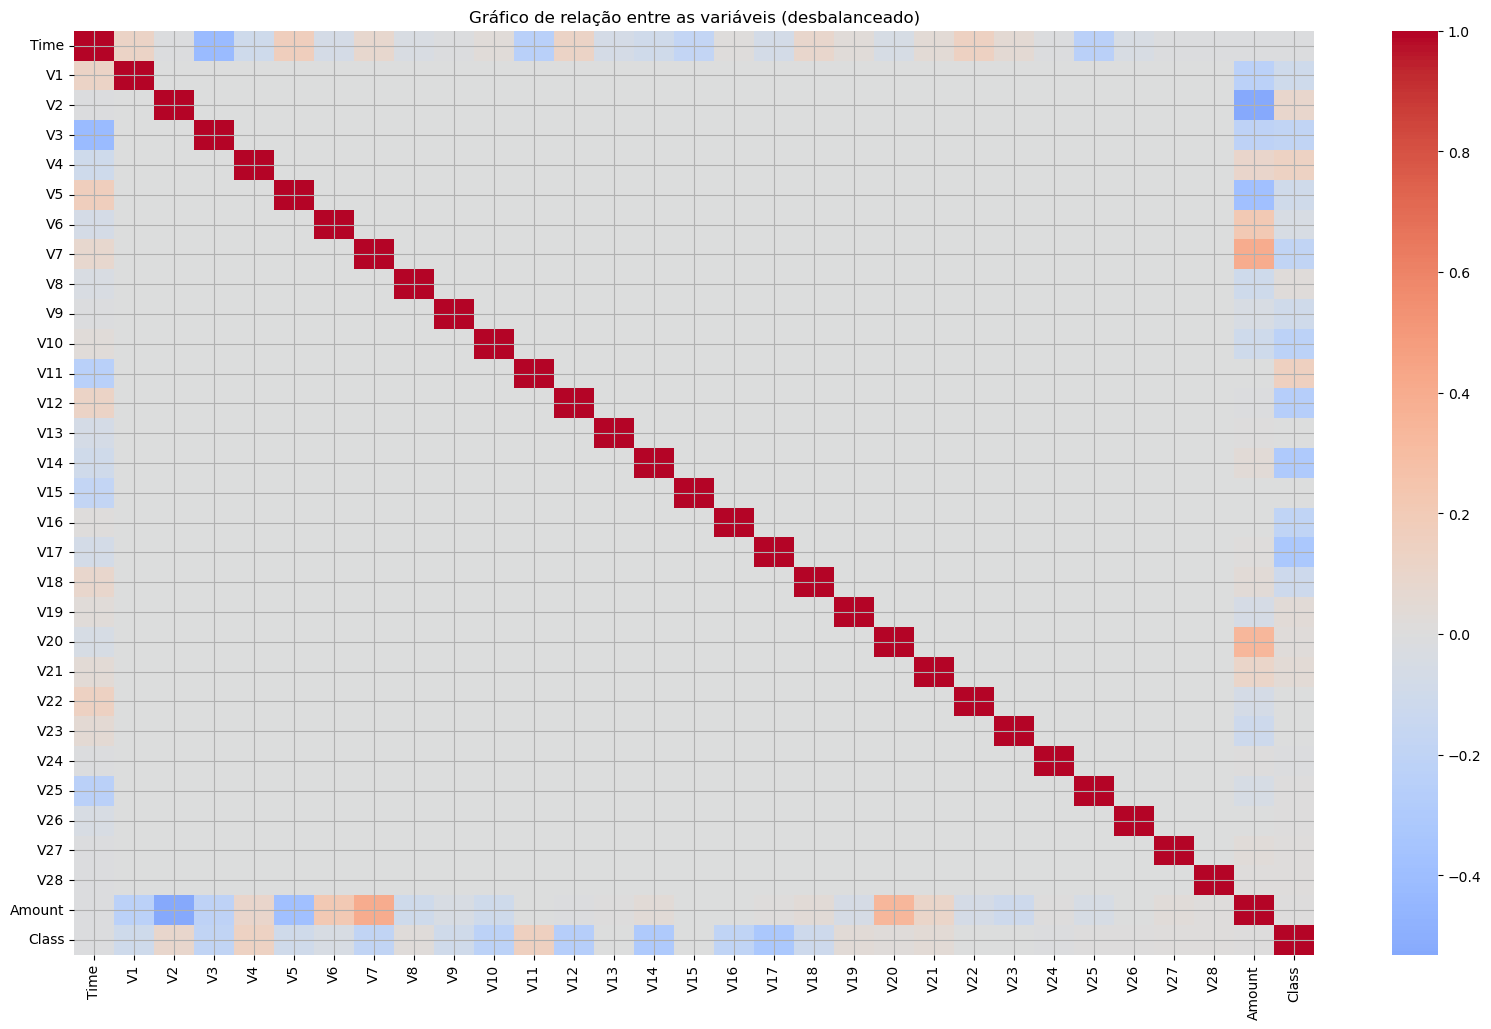

In [13]:
draw_graphics(dataset) # vai printar os dados do dataset original

## **SEPARAÇÃO DAS COLUNAS FEATURES E TARGETS DO DATASET BASE, E DADOS DE TREINO E TESTE DELA**

In [14]:
# Define as colunas para analisar e as colunas alvos
target = dataset['Class']
features = dataset.drop('Class', axis=1)
#features = pd.DataFrame(scaler.fit_transform(features), columns = features.columns, index= features.index)

In [15]:
# Separação dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [16]:
# Lista com os dados originais
datasTest = [X_test, y_test]

## **TESTE DE MODELOS COM DADOS DESBALANCEADOS DESBALANCEADOS**

### MODELOS

In [17]:
datasTrain = [X_train, y_train]
print("\n--- DADOS Dados desbalanceados ---")
print(f"Formato de X_train: {X_train.shape}")
print(f"Distribuição de y_train:\n{y_train.value_counts()}")


--- DADOS Dados desbalanceados ---
Formato de X_train: (227845, 30)
Distribuição de y_train:
Class
0    227451
1       394
Name: count, dtype: int64


#### KNN

In [18]:
modelo_knn = train_model(KNeighborsClassifier(n_jobs=8), datasTrain)

#### LOGISTIC REGRESSION

In [19]:
modelo_lg = train_model(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=8), datasTrain)

#### RANDOM FOREST

In [20]:
modelo_rf = train_model(RandomForestClassifier(random_state=42, n_jobs=8), datasTrain)

## **TESTES DE MODELOS COM O BALANCEAMENTO**

### **OVERSAMPLING**

In [21]:
# Oversampling dos dadso
X_train_over, y_train_over = SMOTE().fit_resample(X_train, y_train)

#### **MODELOS**

In [22]:
# Cria a lista dos dados pós oversampling
datasTrain_over = [X_train_over, y_train_over]

In [23]:
print("\n--- DADOS PÓS OVERSAMPLING ---")
print(f"Novo formato de X_train_over: {X_train_over.shape}")
print(f"Nova distribuição de y_train_over:\n{pd.Series(y_train_over).value_counts()}")


--- DADOS PÓS OVERSAMPLING ---
Novo formato de X_train_over: (454902, 30)
Nova distribuição de y_train_over:
Class
0    227451
1    227451
Name: count, dtype: int64


##### KNN

In [24]:
modelo_knn_over = train_model(KNeighborsClassifier(n_jobs=8), datasTrain_over)

##### LOGISTIC REGRESSION

In [25]:
modelo_lg_over = train_model(LogisticRegression(max_iter=1000, random_state=42, n_jobs=8), datasTrain_over)

##### RANDOM FOREST

In [26]:
modelo_rf_over = train_model(RandomForestClassifier(random_state=42, n_jobs=8), datasTrain_over)

### **UNDERSAMPLING**

In [27]:
# Balanceamento dos dados com undersampling
enn = EditedNearestNeighbours()
X_train_under, y_train_under = enn.fit_resample(X_train, y_train)

#### **MODELOS**

In [28]:
# Cria lista dos dados pós undersampling
datasTrain_under = [X_train_under, y_train_under]

In [29]:
print("\n--- DADOS PÓS UNDERSAMPLING ---")
print(f"Novo formato de X_train_under: {X_train_under.shape}")
print(f"Nova distribuição de y_train_under:\n{pd.Series(y_train_under).value_counts()}")


--- DADOS PÓS UNDERSAMPLING ---
Novo formato de X_train_under: (227709, 30)
Nova distribuição de y_train_under:
Class
0    227315
1       394
Name: count, dtype: int64


#### KNN

In [30]:
modelo_knn_under = train_model(KNeighborsClassifier(), datasTrain_under)

#### LOGISTIC REGRESSION

In [31]:
modelo_lg_under = train_model(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), datasTrain_under)

#### RANDOM FOREST

In [32]:
modelo_rf_under = train_model(RandomForestClassifier(random_state=42), datasTrain_under)

Exception ignored in: <function ResourceTracker.__del__ at 0x76b5c7d8ab60>
Traceback (most recent call last):
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x751976b82b60>
Traceback (most recent call last):
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function Resour

### **MÉTODO HÍBRIDO**

In [33]:
# SMOTE + ENN para o balaceamento com método híbrido
smoteenn = SMOTEENN(n_jobs=8)
X_train_hib, y_train_hib = smoteenn.fit_resample(X_train, y_train)

#### **MODELOS**

In [34]:
# Lista pós aplica os métodos
datasTrain_hib = [X_train_hib, y_train_hib]

In [35]:
print("\n--- DADOS PÓS MÉTODO HÍBRIDO ---")
print(f"Novo formato de X_train_hib: {X_train_hib.shape}")
print(f"Nova distribuição de y_train_hib:\n{pd.Series(y_train_hib).value_counts()}")


--- DADOS PÓS MÉTODO HÍBRIDO ---
Novo formato de X_train_hib: (454505, 30)
Nova distribuição de y_train_hib:
Class
1    227451
0    227054
Name: count, dtype: int64


#### KNN

In [36]:
modelo_knn_hib = train_model(KNeighborsClassifier(n_jobs=8), datasTrain_hib)

#### LOGISTIC REGRESSION

In [37]:
modelo_lg_hib = train_model(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=8), datasTrain_hib)

#### RANDOM FOREST

In [38]:
modelo_rf_hib = train_model(RandomForestClassifier(random_state=42, n_jobs=8), datasTrain_hib)

# IMPRESSÃO DOS RESULTADOS

*OBS.: OS DICIONÁRIOS(dict's) CRIADOS DURANTE AS IMPRESSÕES SERÃO USADOS PARA A IMPRESSÃO E SALVAMENTO DOS GRÁFICOS DAS CURVAS AUC-ROC E PRECISION-RECALL CONDENSADOS EM DUAS IMAGENS: UMA PARA O GRÁFICO DO AUC-ROC E OUTRO PARA O PRECISION-RECALL*

## **DESBALANCEADOS**

### KNN

Acurácia do modelo: 1.00

Recall do modelo: 0.81

Precision do modelo: 0.92

F1_Score do modelo: 0.86

Precision-Recall: 0.89
ROC-AUC: 0.94
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Matriz de Confusão - KNN - Desbalanceado:


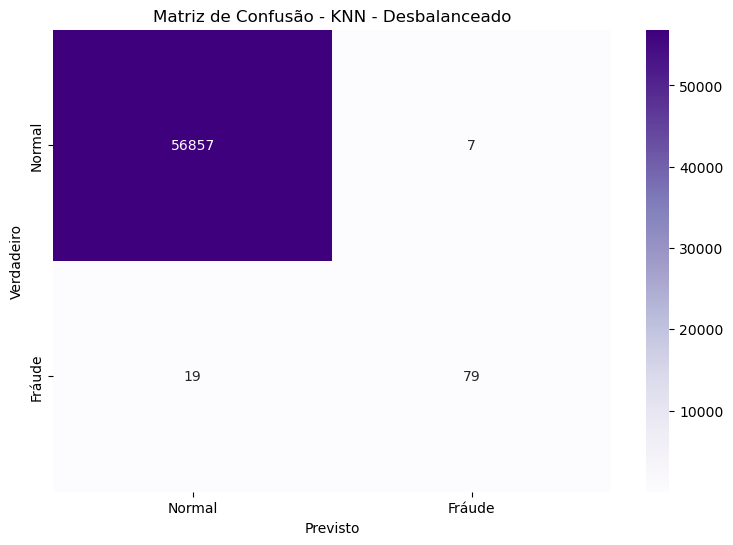

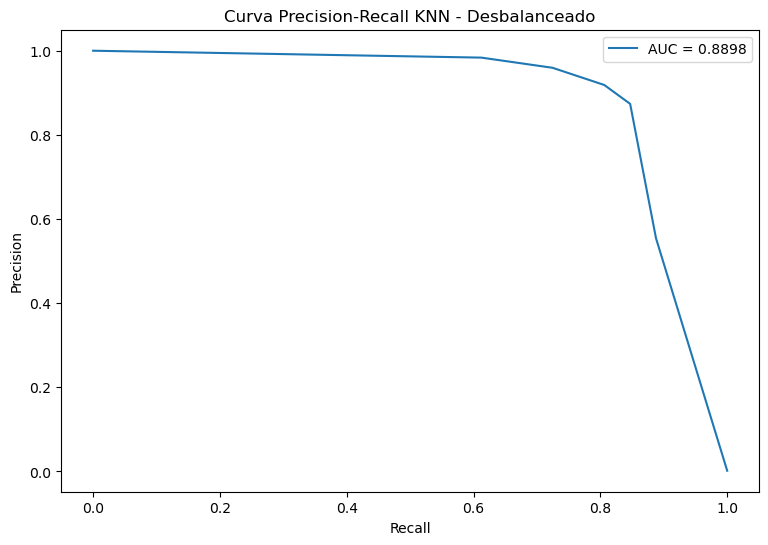

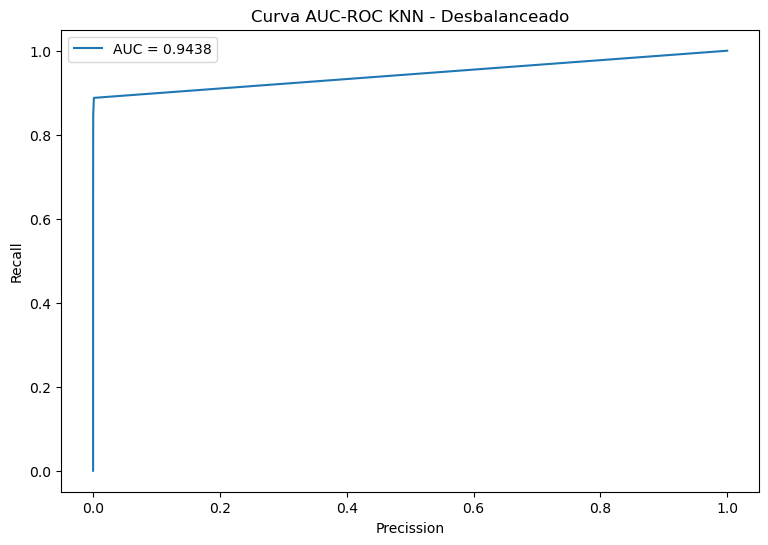

In [39]:
dictKnn = print_infos(modelo_knn, datasTest, "KNN", "Desbalanceado")

### REGRESSÃO LOGÍSTICA

Acurácia do modelo: 0.98

Recall do modelo: 0.92

Precision do modelo: 0.06

F1_Score do modelo: 0.11

Precision-Recall: 0.76
ROC-AUC: 0.97
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Matriz de Confusão - Regressao-Logistica - Desbalanceado:


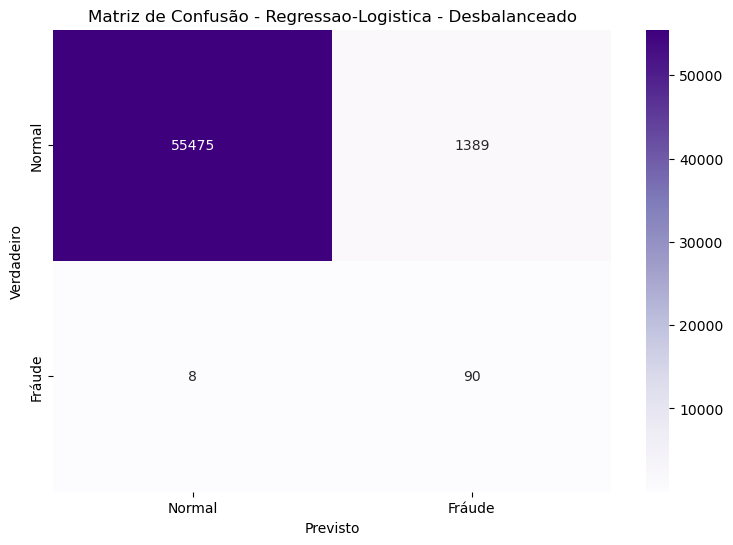

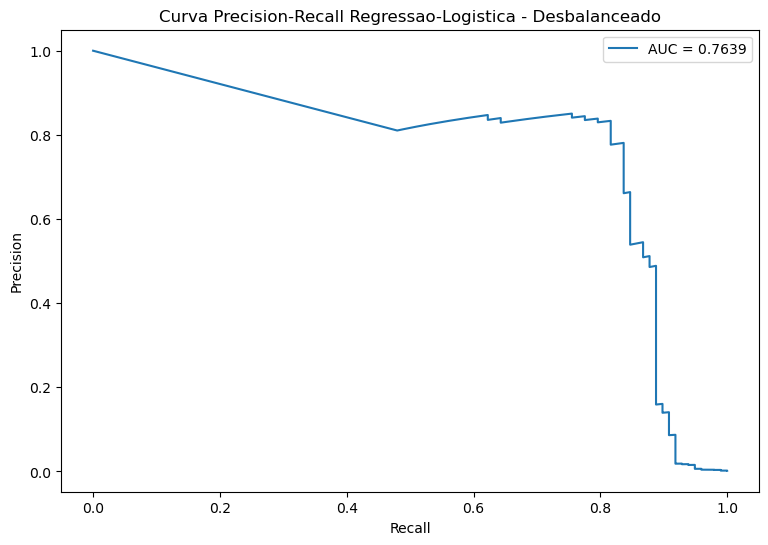

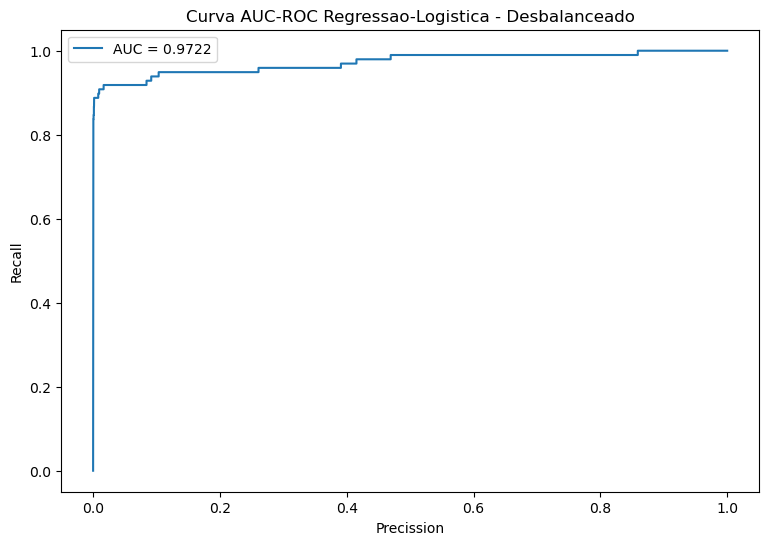

In [40]:
dictLgRg = print_infos(modelo_lg, datasTest, "Regressao-Logistica", "Desbalanceado")

### RANDOM FOREST

Acurácia do modelo: 1.00

Recall do modelo: 0.82

Precision do modelo: 0.94

F1_Score do modelo: 0.87

Precision-Recall: 0.88
ROC-AUC: 0.96
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Matriz de Confusão - Random-Forest - Desbalanceado:


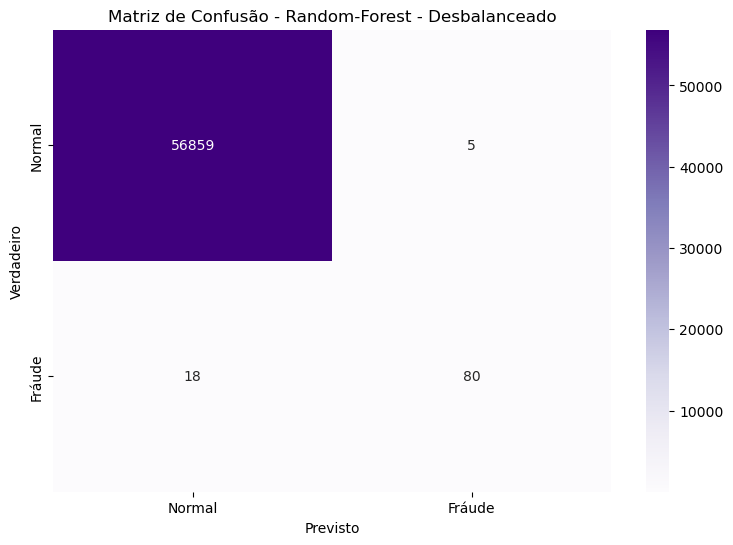

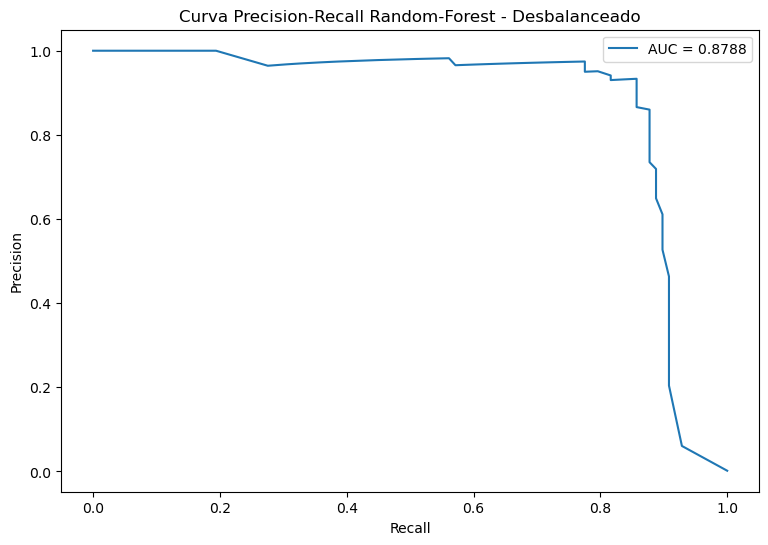

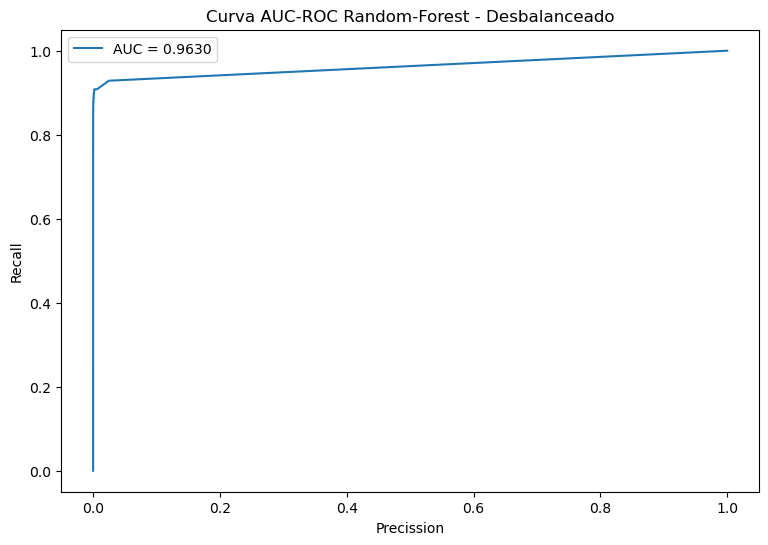

In [41]:
dictRf = print_infos(modelo_rf, datasTest, "Random-Forest", "Desbalanceado")

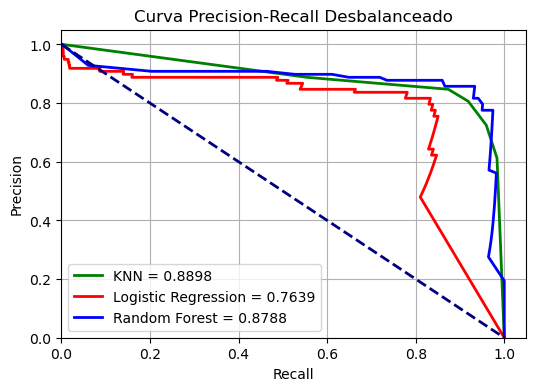

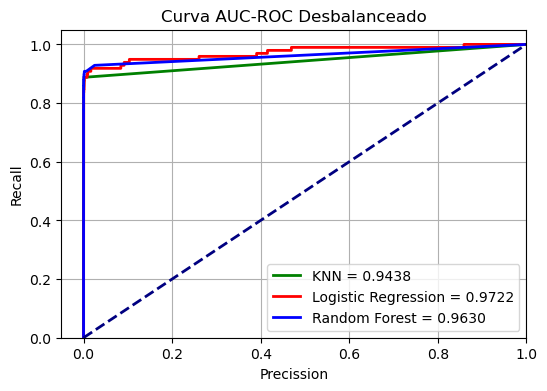

In [42]:
print_curve(dictKnn, dictLgRg, dictRf, "Desbalanceado")

## **OVERSAMPLING**

### KNN

Acurácia do modelo: 1.00

Recall do modelo: 0.88

Precision do modelo: 0.46

F1_Score do modelo: 0.61

Precision-Recall: 0.77
ROC-AUC: 0.95
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.88      0.61        98

    accuracy                           1.00     56962
   macro avg       0.73      0.94      0.80     56962
weighted avg       1.00      1.00      1.00     56962

Matriz de Confusão - KNN - SMOTE:


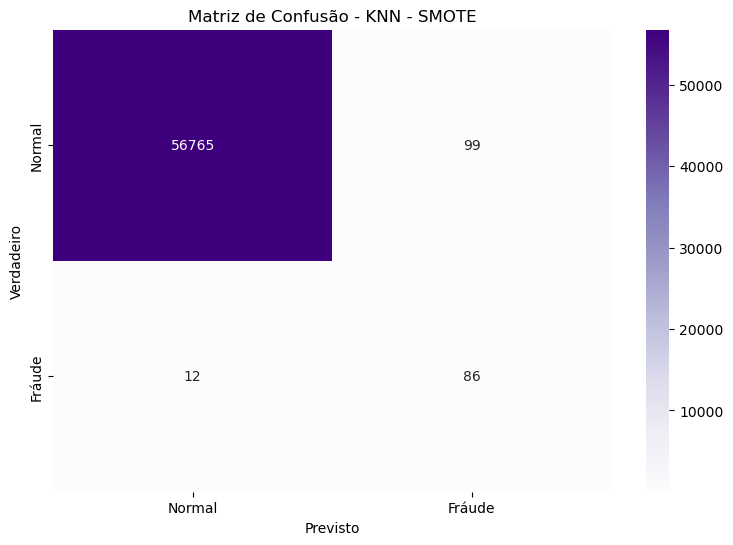

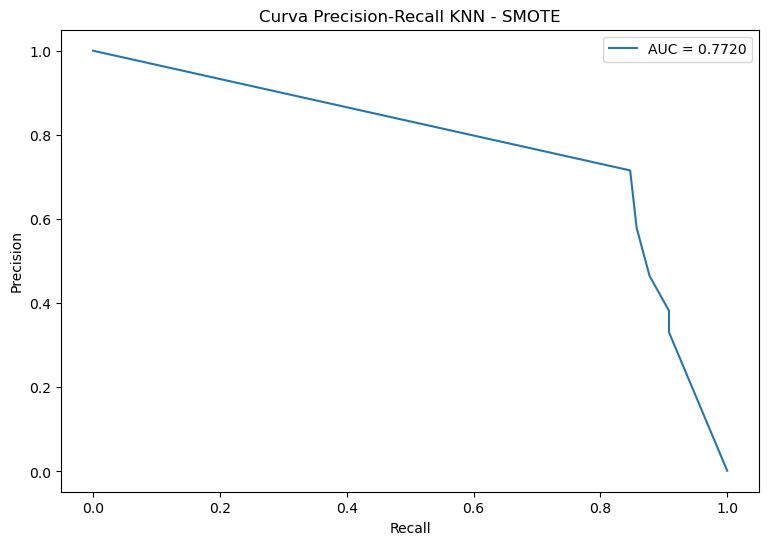

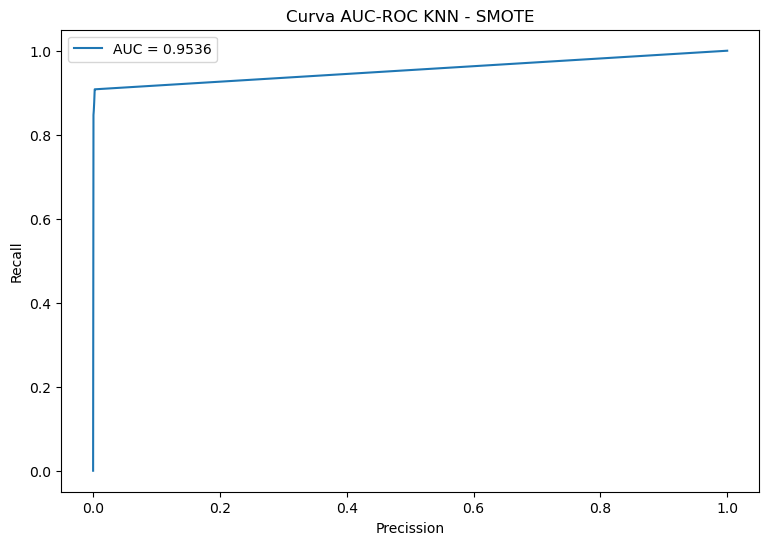

In [43]:
dictKnn_over = print_infos(modelo_knn_over, datasTest, "KNN", "SMOTE")

### REGRESSÃO LOGÍSTICA

Acurácia do modelo: 0.97

Recall do modelo: 0.92

Precision do modelo: 0.06

F1_Score do modelo: 0.11

Precision-Recall: 0.77
ROC-AUC: 0.97
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Matriz de Confusão - Regressao-Logistica - SMOTE:


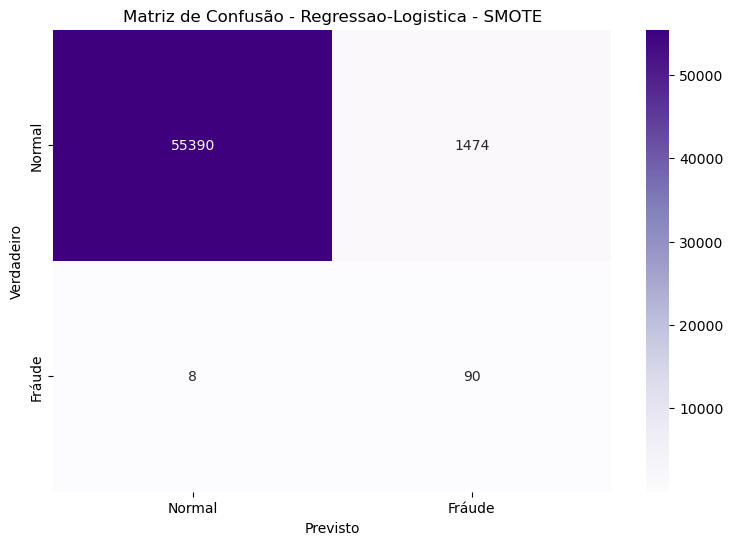

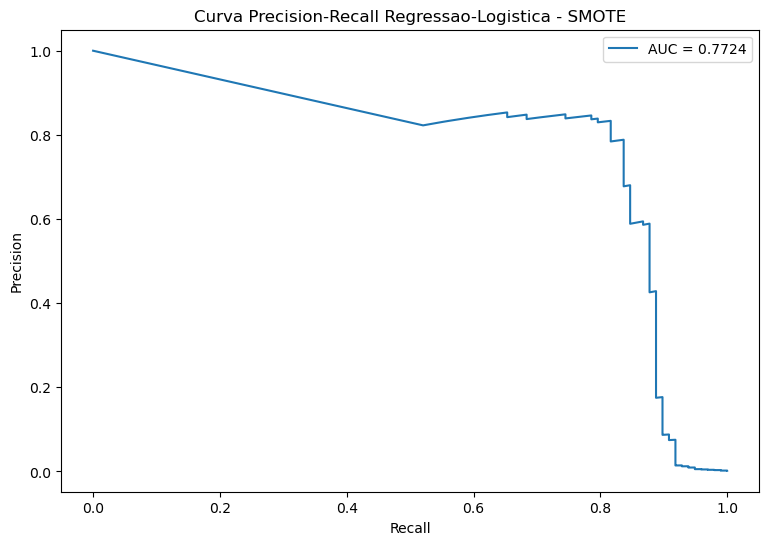

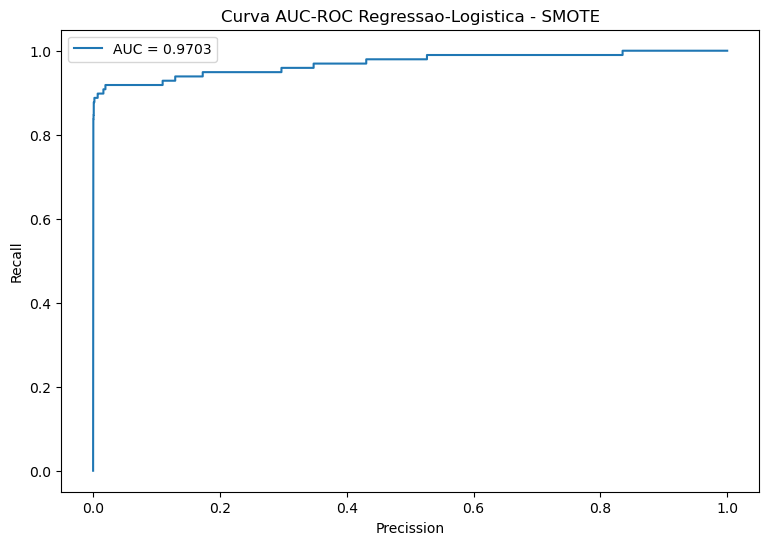

In [44]:
dictLgRg_over = print_infos(modelo_lg_over, datasTest,  "Regressao-Logistica", "SMOTE")

### RANDOM FOREST

Acurácia do modelo: 1.00

Recall do modelo: 0.82

Precision do modelo: 0.85

F1_Score do modelo: 0.83

Precision-Recall: 0.88
ROC-AUC: 0.97
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Matriz de Confusão - Random-Forest - SMOTE:


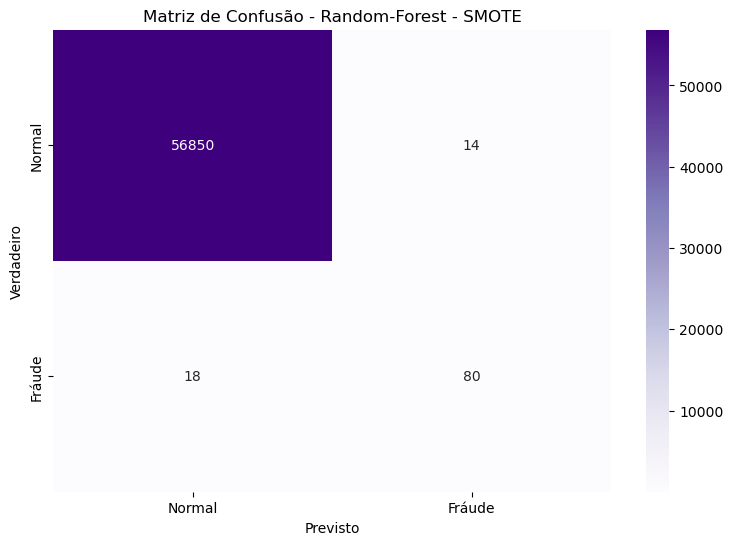

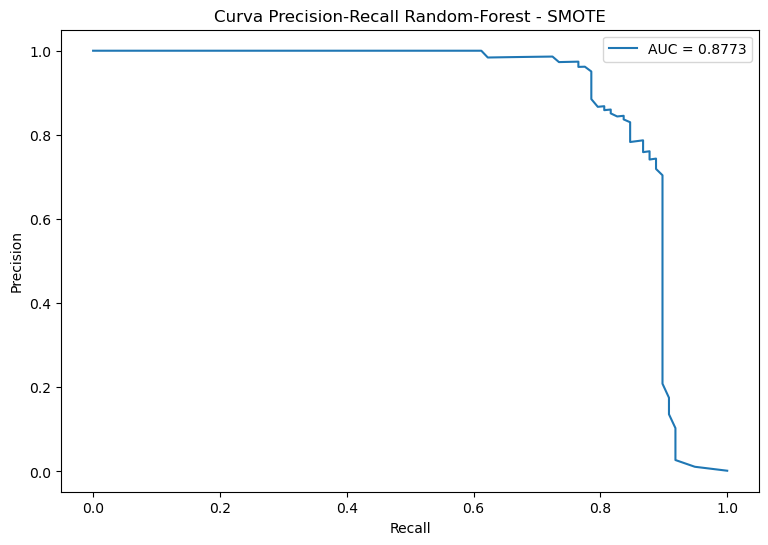

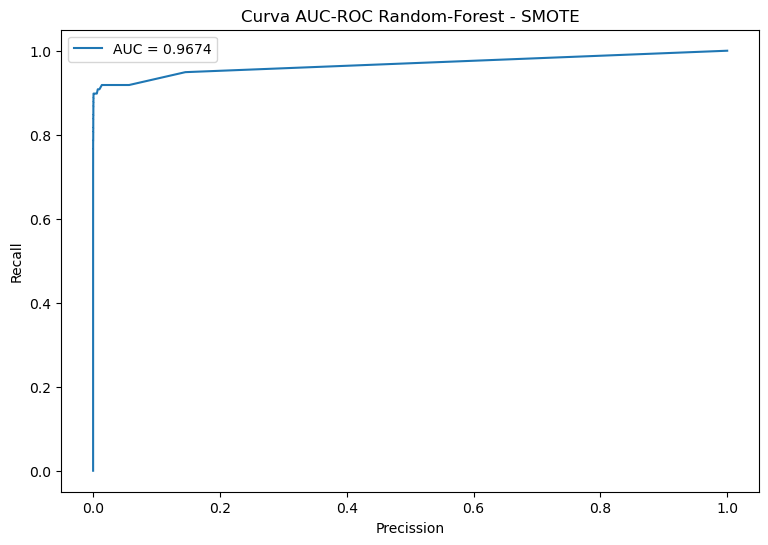

In [45]:
dictRf_over = print_infos(modelo_rf_over, datasTest,  "Random-Forest", "SMOTE")

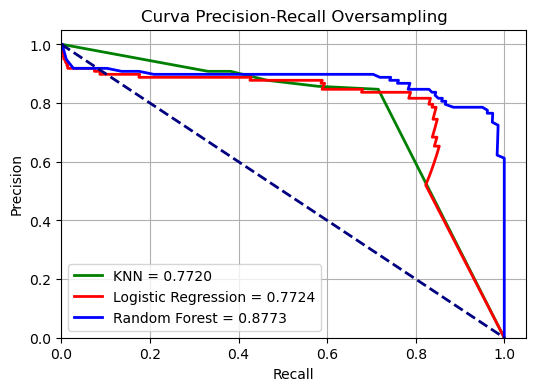

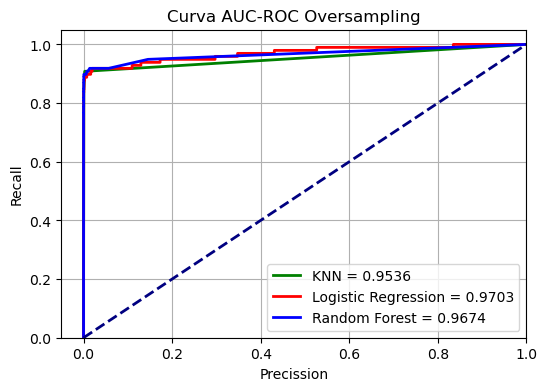

In [46]:
print_curve(dictKnn_over, dictLgRg_over, dictRf_over, "Oversampling")

## **UNDERSAMPLING**

### KNN

Acurácia do modelo: 1.00

Recall do modelo: 0.82

Precision do modelo: 0.84

F1_Score do modelo: 0.83

Precision-Recall: 0.86
ROC-AUC: 0.94
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Matriz de Confusão - KNN - ENN:


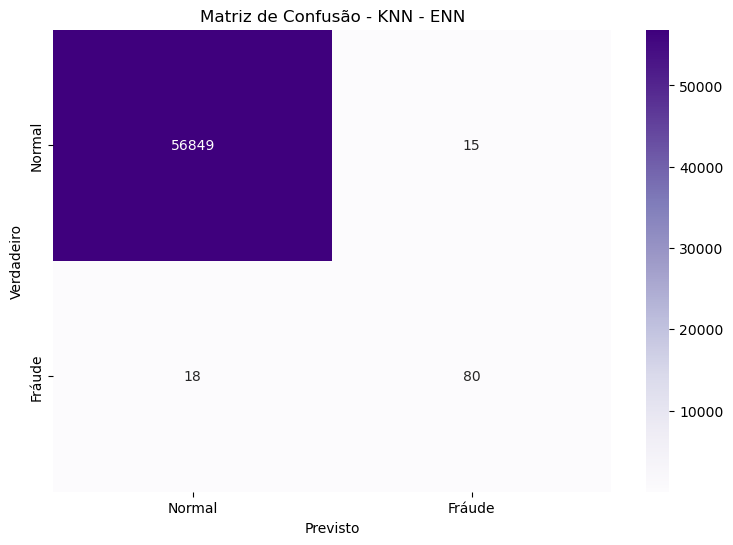

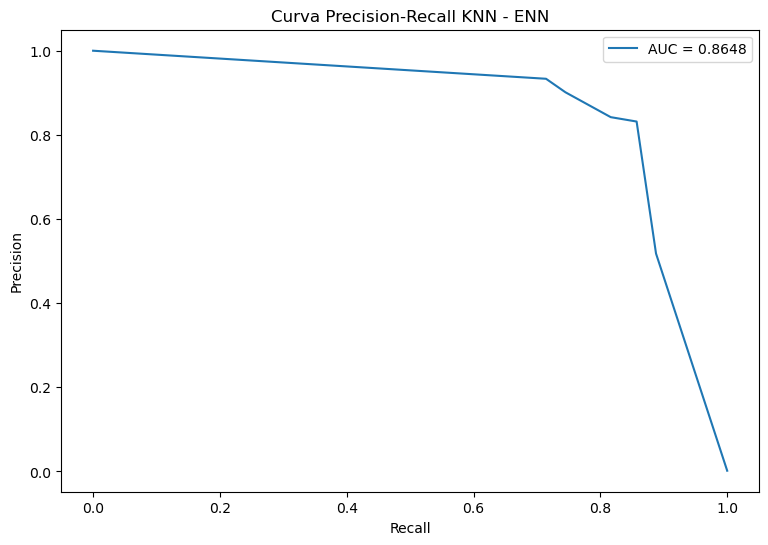

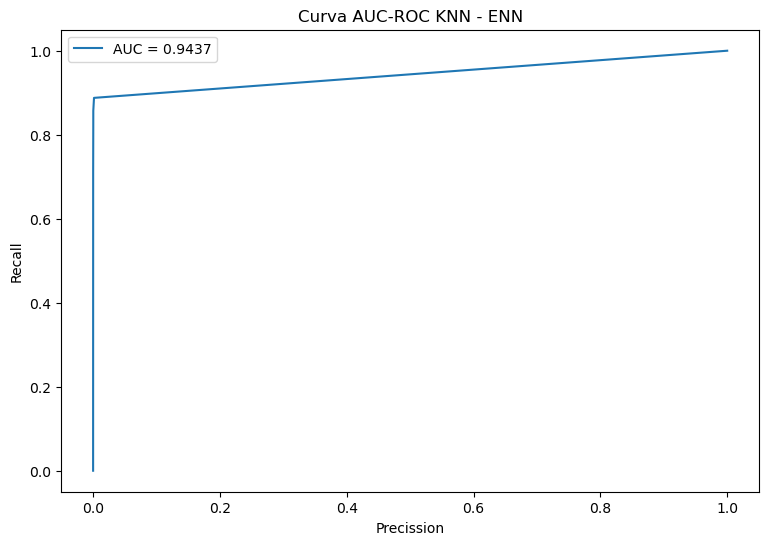

In [47]:
dictKnn_under = print_infos(modelo_knn_under, datasTest, "KNN", "ENN")

### REGRESSÃO LOGÍSTICA

Acurácia do modelo: 0.97

Recall do modelo: 0.92

Precision do modelo: 0.06

F1_Score do modelo: 0.11

Precision-Recall: 0.78
ROC-AUC: 0.97
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Matriz de Confusão - Regressao-Logistica - ENN:


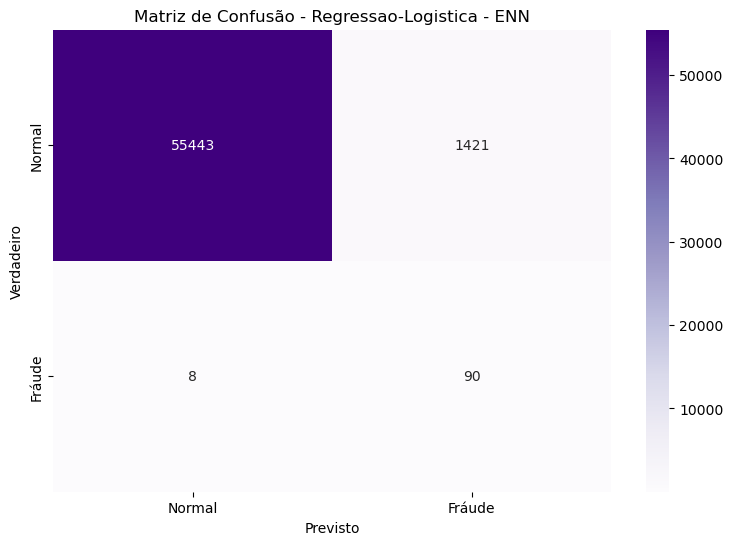

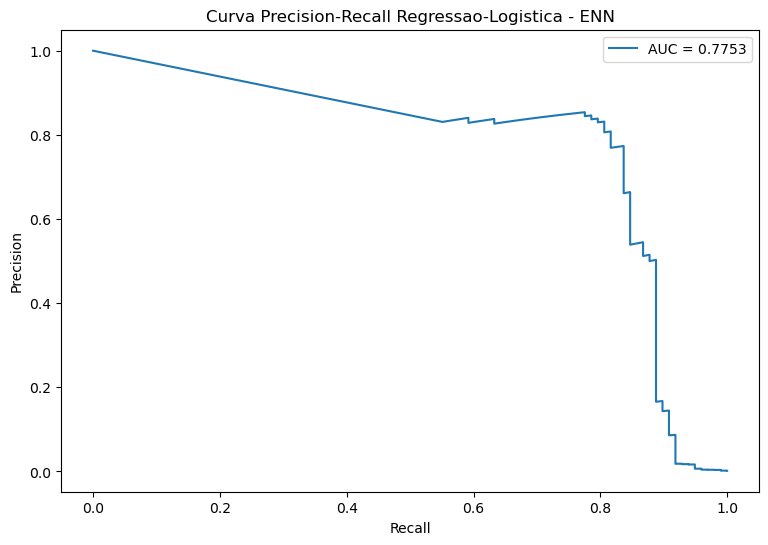

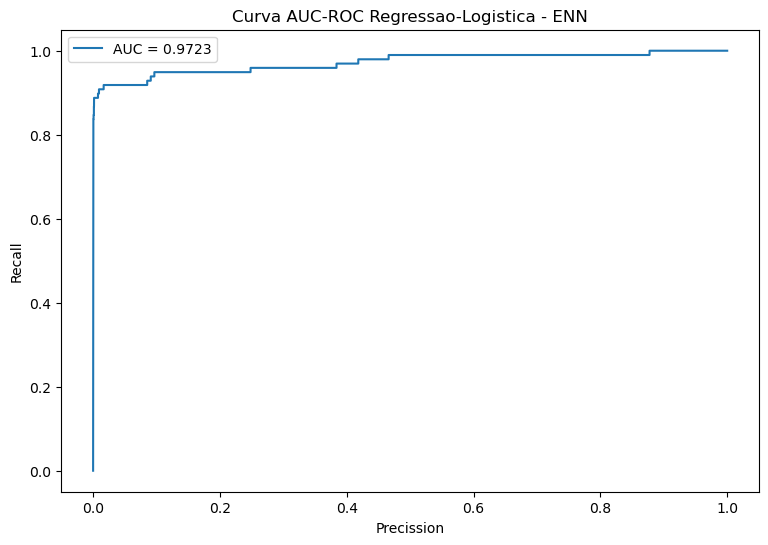

In [48]:
dictLgRg_under = print_infos(modelo_lg_under, datasTest, "Regressao-Logistica", "ENN")

### RANDOM FOREST

Acurácia do modelo: 1.00

Recall do modelo: 0.85

Precision do modelo: 0.86

F1_Score do modelo: 0.85

Precision-Recall: 0.85
ROC-AUC: 0.95
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.85      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Matriz de Confusão - Random-Forest - ENN:


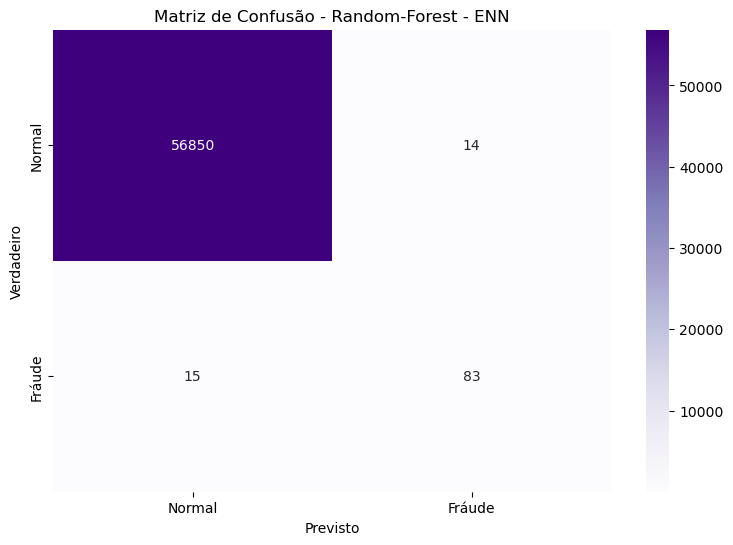

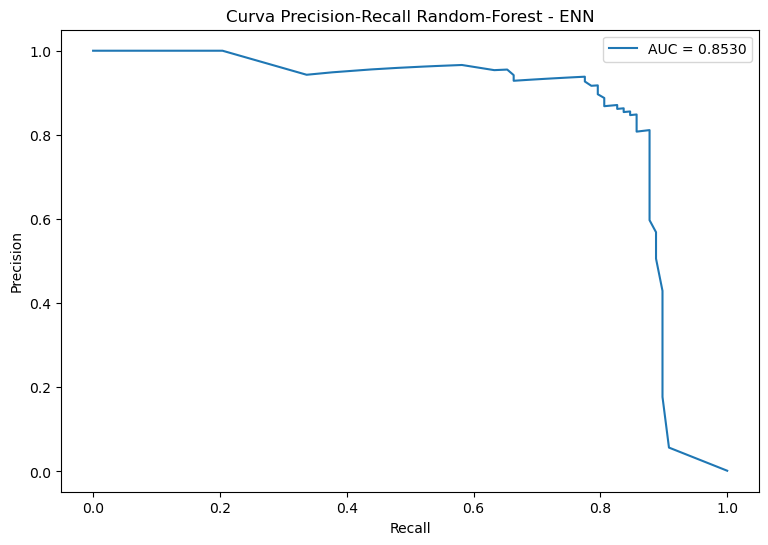

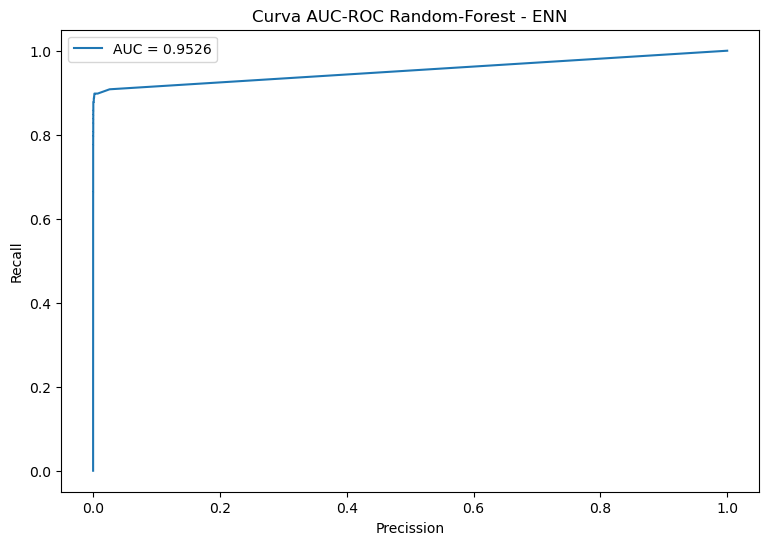

In [49]:
dictRf_under = print_infos(modelo_rf_under, datasTest, "Random-Forest", "ENN")

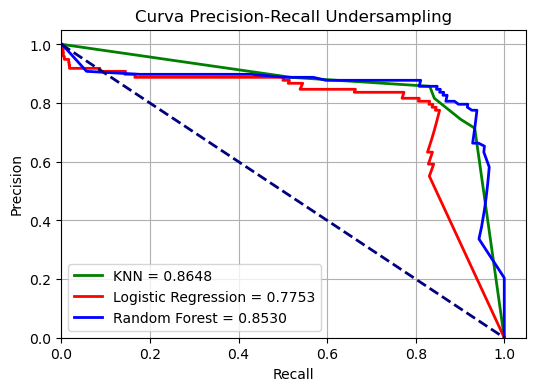

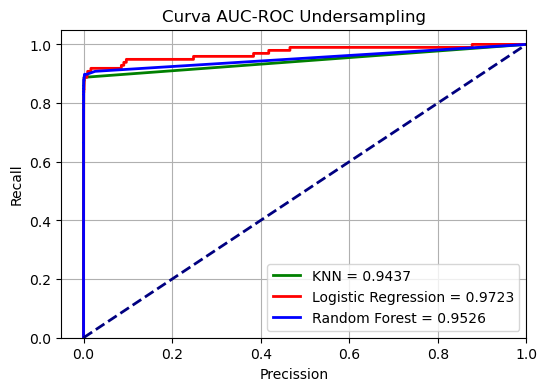

In [50]:
print_curve(dictKnn_under, dictLgRg_under, dictRf_under, "Undersampling")

## **HÍBRIDO**

### KNN

Acurácia do modelo: 1.00

Recall do modelo: 0.88

Precision do modelo: 0.39

F1_Score do modelo: 0.54

Precision-Recall: 0.72
ROC-AUC: 0.95
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.39      0.88      0.54        98

    accuracy                           1.00     56962
   macro avg       0.70      0.94      0.77     56962
weighted avg       1.00      1.00      1.00     56962

Matriz de Confusão - KNN - Metodo-hibrido-SMOTE-ENN:


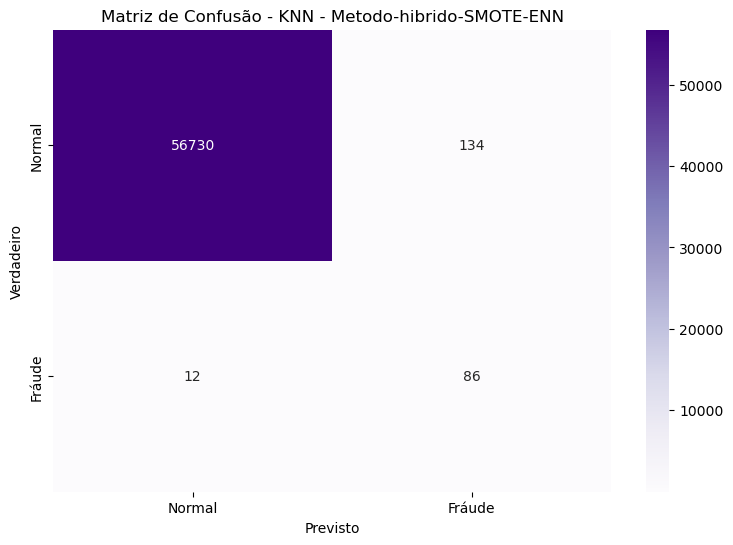

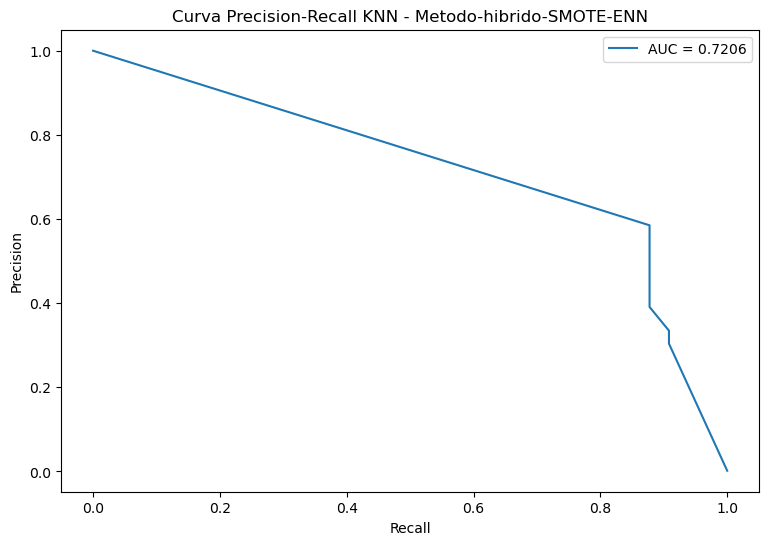

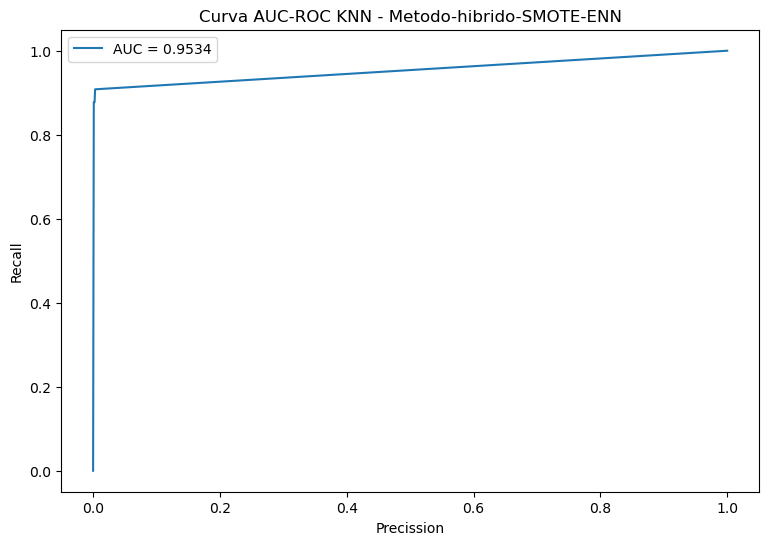

In [51]:
dictKnn_hib = print_infos(modelo_knn_hib, datasTest, "KNN", "Metodo-hibrido-SMOTE-ENN")

### REGRESSÃO LOGÍSTICA

Acurácia do modelo: 0.97

Recall do modelo: 0.92

Precision do modelo: 0.06

F1_Score do modelo: 0.10

Precision-Recall: 0.79
ROC-AUC: 0.97
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962

Matriz de Confusão - Regressao-Logistica - Metodo-hibrido-SMOTE-ENN:


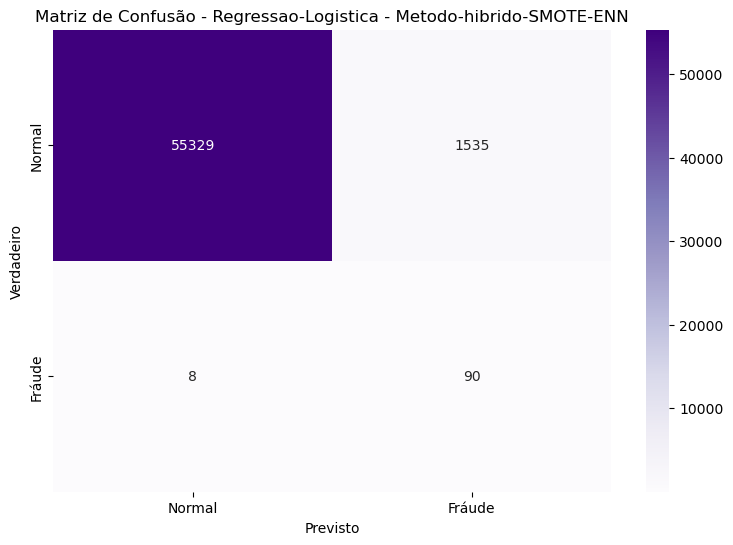

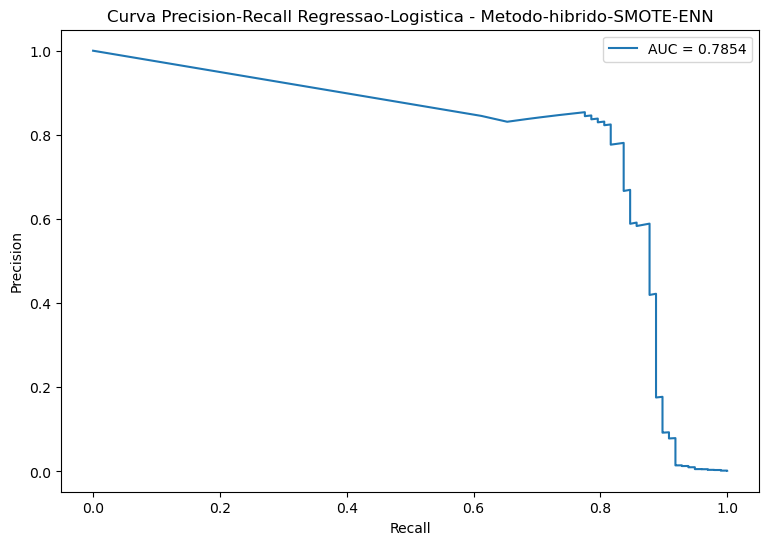

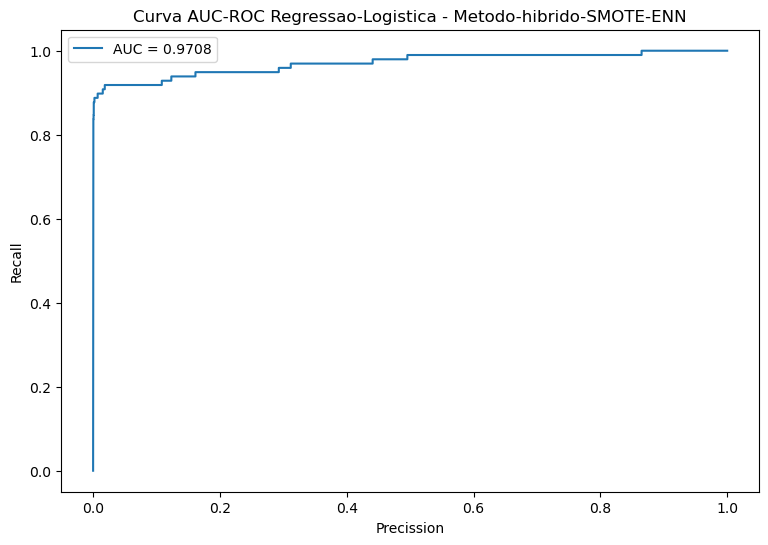

In [52]:
dictLgRg_hib = print_infos(modelo_lg_hib, datasTest, "Regressao-Logistica", "Metodo-hibrido-SMOTE-ENN")

### RANDOM FOREST

Acurácia do modelo: 1.00

Recall do modelo: 0.84

Precision do modelo: 0.78

F1_Score do modelo: 0.81

Precision-Recall: 0.87
ROC-AUC: 0.96
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.84      0.81        98

    accuracy                           1.00     56962
   macro avg       0.89      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Matriz de Confusão - Random-Forest - Metodo-hibrido-SMOTE-ENN:


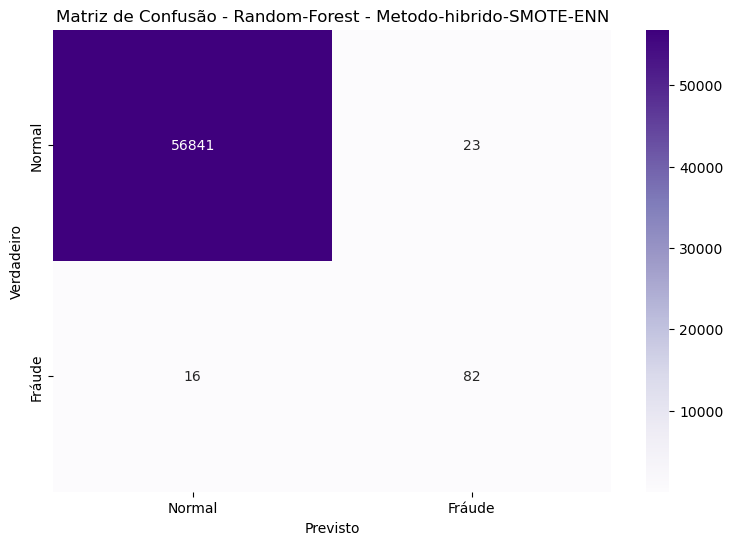

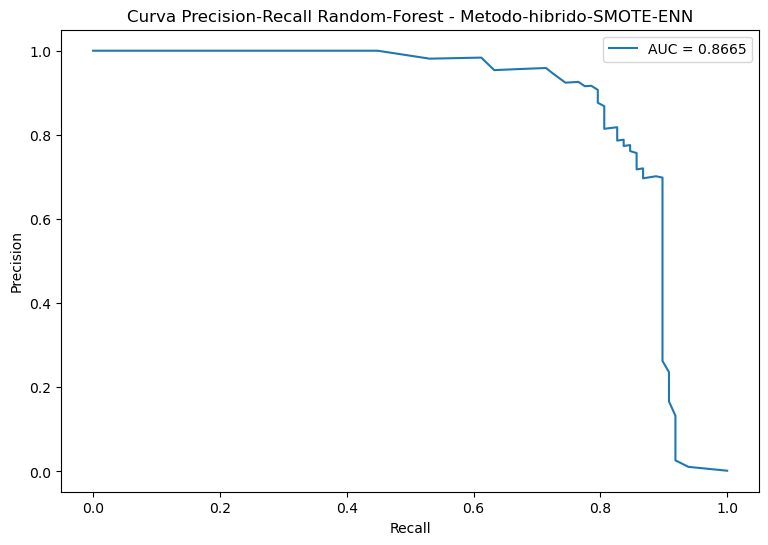

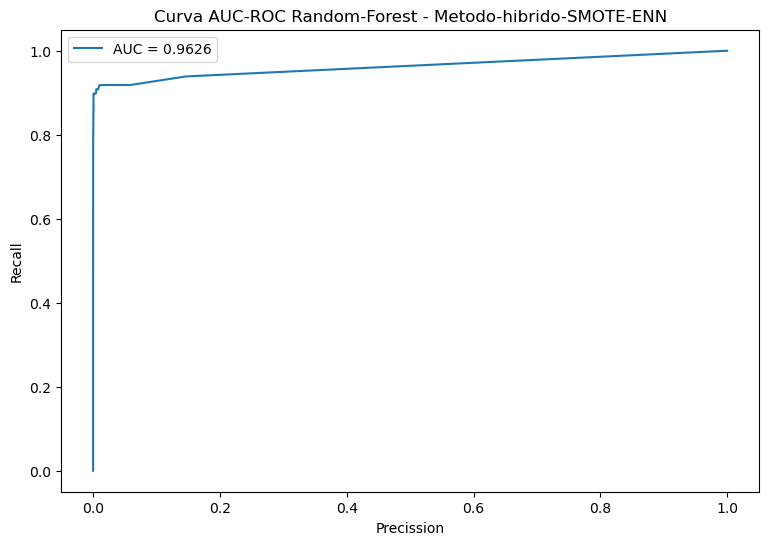

In [53]:
dictRf_hib = print_infos(modelo_rf_hib, datasTest, "Random-Forest", "Metodo-hibrido-SMOTE-ENN")

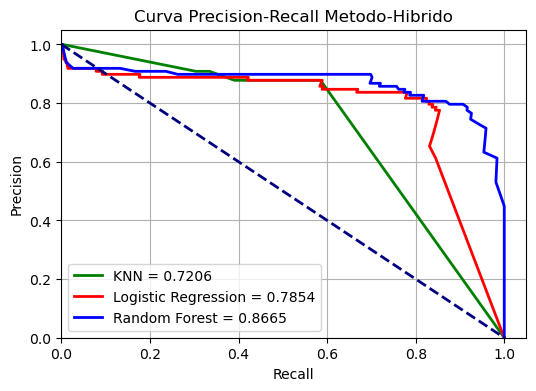

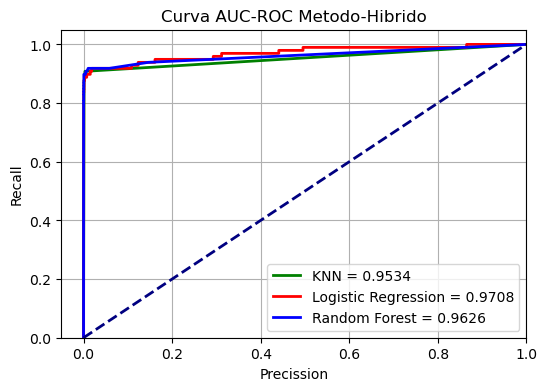

Exception ignored in: <function ResourceTracker.__del__ at 0x70fe4fd86b60>
Traceback (most recent call last):
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7c111237eb60>
Traceback (most recent call last):
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/caique-s/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function Resour

In [54]:
print_curve(dictKnn_hib, dictLgRg_hib, dictRf_hib, "Metodo-Hibrido")